# Mask R-CNN for Recycling Object Segmentation

This notebook is adopted from [Russ's Mask R-CNN notebook](https://colab.research.google.com/github/RussTedrake/manipulation/blob/master/segmentation_train.ipynb#scrollTo=xA8sBvuHNNH1).


In [2]:
# !pip install cython
# # Install pycocotools, the version by default in Colab
# # has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
# !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# # Download TorchVision repo to use some files from
# # references/detection
# !git clone https://github.com/pytorch/vision.git
# !cd vision && git checkout v0.3.0
# !cp vision/references/detection/utils.py ./
# !cp vision/references/detection/transforms.py ./
# !cp vision/references/detection/coco_eval.py ./
# !cp vision/references/detection/engine.py ./
# !cp vision/references/detection/coco_utils.py ./

# Imports
import fnmatch
import json
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
from PIL import Image
from IPython.display import display

import torch
import torch.utils.data
from torchvision import transforms

classes = ["cola_can", "bottle", "Banana", "Orange", "coffee"]

def colorize_labels(image):
    """Colorizes labels."""
    cc = mpl.colors.ColorConverter()
    color_cycle = plt.rcParams["axes.prop_cycle"]
    colors = np.array([cc.to_rgb(c["color"]) for c in color_cycle])
    bg_color = [0, 0, 0]
    image = np.squeeze(image)
    background = np.zeros(image.shape[:2], dtype=bool)
    for label in reserved_labels:
        background |= image == int(label)
    foreground = image[np.logical_not(background)]
    color_image = colors[image % len(colors)]
    color_image[background] = bg_color
    return color_image


In [7]:
# A = {"5": "coffee", "1": "cola", "3": "Banana", "4": "Orange", "2": "bottle"}
# obj_ids = np.asarray(list(A.keys()))
# print(obj_ids)
# labels = [classes.index(A[id]) for id in obj_ids]
# print(labels)

['5' '1' '3' '4' '2']
[4, 0, 2, 3, 1]


# Loading dataset into PyTorch

In [3]:
# To-do: change to local directory
dataset_path = '/tmp/clutter_maskrcnn_data'

class BinPickingDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.num_images = len(fnmatch.filter(os.listdir(root),'*.png'))
        self.transforms = transforms

    def __getitem__(self, idx):
        filename_base = os.path.join(self.root, f"{idx:04d}")

        img = Image.open(filename_base + ".png").convert("RGB")
        mask = np.squeeze(np.load(filename_base + "_mask.npy"))

        with open(filename_base + ".json", "r") as f:
            instance_id_to_class_name = json.load(f)

        # instances are encoded as different colors
        obj_ids = np.asarray(list(instance_id_to_class_name.keys()))
        count = (mask == np.int16(obj_ids)[:, None, None]).sum(axis=2).sum(axis=1)
        
        # discard objects instances with less than 10 pixels
        obj_ids = obj_ids[count >= 10]

        labels = [classes.index(instance_id_to_class_name[id]) for id in obj_ids]
        obj_ids = np.int16(np.asarray(obj_ids))

        # split the color-encoded mask into a set of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return self.num_images


Let's check the output of our dataset.

cola_can
(640, 480, 3)


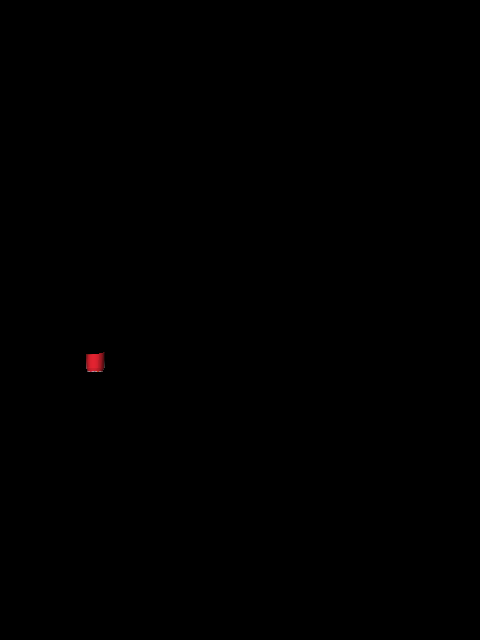

In [63]:
import PIL
dataset = BinPickingDataset(dataset_path)
# dataset[0][1]["boxes"]
i = 2
j = 100
can_mask = dataset[j][1]["masks"][i]
label_idx = dataset[j][1]["labels"][i]
print(classes[label_idx])
convert_tensor = transforms.ToTensor()
img = convert_tensor(dataset[j][0])
img = img * can_mask * 255
img = np.array(img, dtype=np.uint8)
print(img.T.shape)
img = PIL.Image.fromarray(img.T)
img.convert("RGB")

# Define the network

This cell is where the magic begins to happen.  We load a network that is pre-trained on the COCO dataset, then replace the network head with a new (untrained) network with the right number of outputs for our YCB recognition/segmentation task.

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

# Transforms

Let's write some helper functions for data augmentation / transformation, which leverages the functions in torchvision `refereces/detection`. 


In [5]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

# Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [6]:
# use our dataset and defined transformations
dataset = BinPickingDataset(dataset_path, get_transform(train=True))
dataset_test = BinPickingDataset(dataset_path, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [10]:
device = torch.device('cpu')

num_classes = len(classes)+1

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [12]:
# let's train it for 3 epochs
num_epochs = 3

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/225]  eta: 0:53:56  lr: 0.000027  loss: 4.2232 (4.2232)  loss_classifier: 1.4939 (1.4939)  loss_box_reg: 0.6150 (0.6150)  loss_mask: 2.0760 (2.0760)  loss_objectness: 0.0319 (0.0319)  loss_rpn_box_reg: 0.0063 (0.0063)  time: 14.3828  data: 0.1717  max mem: 0
Epoch: [0]  [ 10/225]  eta: 0:58:01  lr: 0.000250  loss: 4.0366 (3.6423)  loss_classifier: 1.3375 (1.2300)  loss_box_reg: 0.5879 (0.5733)  loss_mask: 1.9038 (1.7527)  loss_objectness: 0.0796 (0.0790)  loss_rpn_box_reg: 0.0061 (0.0073)  time: 16.1913  data: 0.0236  max mem: 0
Epoch: [0]  [ 20/225]  eta: 0:56:34  lr: 0.000473  loss: 2.3200 (2.8195)  loss_classifier: 0.6628 (0.9220)  loss_box_reg: 0.5949 (0.5873)  loss_mask: 0.9898 (1.2185)  loss_objectness: 0.0517 (0.0825)  loss_rpn_box_reg: 0.0063 (0.0093)  time: 16.6692  data: 0.0094  max mem: 0
Epoch: [0]  [ 30/225]  eta: 0:54:25  lr: 0.000696  loss: 1.7080 (2.4174)  loss_classifier: 0.5397 (0.7843)  loss_box_reg: 0.6050 (0.6014)  loss_mask: 0.4741 (0.9611)  loss_

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

If you're going to leave this running for a bit, I recommend scheduling the following cell to run immediately (so that you don't lose your work).

In [13]:
torch.save(model.state_dict(), 'recycling_maskrcnn_model.pt')

In [11]:
# def load_model(num_classes):

#     # load an instance segmentation model pre-trained on COCO
#     model = torchvision.models.detection.maskrcnn_resnet50_fpn(
#         weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT, progress=False)

#     # get the number of input features for the classifier
#     in_features = model.roi_heads.box_predictor.cls_score.in_features
#     # replace the pre-trained head with a new one
#     model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#     # now get the number of input features for the mask classifier
#     in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
#     hidden_layer = 256
#     # and replace the mask predictor with a new one
#     model.roi_heads.mask_predictor = MaskRCNNPredictor(
#         in_features_mask, hidden_layer, num_classes)

#     return model

# ## Load model
# MODEL_PATH = 'recycling_maskrcnn_model.pt'
# num_classes = 6
# model = load_model(num_classes)
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
# model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

Now that training has finished, let's have a look at what it actually predicts in a test image

In [68]:
# pick one image from the test set
img, _ = dataset_test[37]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [69]:
prediction

[{'boxes': tensor([[291.1361, 176.4793, 322.8891, 215.8008],
          [576.4231, 189.0029, 609.5348, 218.9267],
          [485.1035, 163.2864, 543.9205, 215.0365],
          [316.8373, 147.5108, 381.0456, 273.5193],
          [354.3519, 196.2896, 376.1157, 234.4380],
          [290.4551, 168.5497, 378.1140, 235.3398],
          [318.6597, 178.8280, 373.6592, 235.6881],
          [320.6095, 186.3544, 374.4398, 235.8605],
          [295.7040, 155.2069, 371.9403, 241.1254],
          [291.2040, 165.6231, 348.3762, 215.6560],
          [471.0983, 182.5972, 495.4358, 205.4626],
          [321.2011, 149.5710, 359.1567, 228.7711],
          [471.6722, 183.7677, 493.8216, 204.0346],
          [295.8467, 151.8953, 380.4525, 288.8845],
          [471.3425, 184.4451, 496.0175, 206.4021],
          [481.2116, 165.5565, 539.2366, 212.9579],
          [512.4828, 164.3755, 544.0128, 207.0080],
          [291.4522, 176.6078, 322.0596, 194.5558],
          [475.6648, 181.6411, 512.2384, 212.6849],
   

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

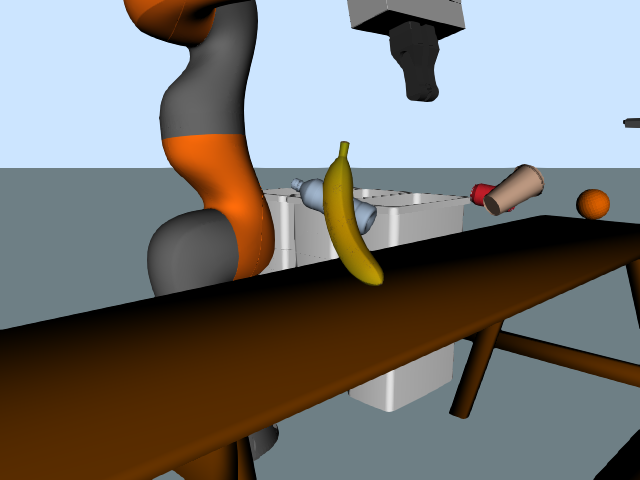

In [70]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

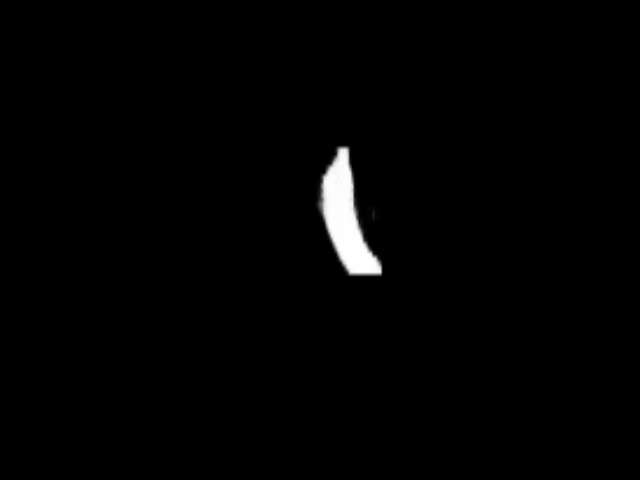

In [76]:
Image.fromarray(prediction[0]['masks'][3, 0].mul(255).byte().cpu().numpy())